# Customer Clustering: Multi-Perspective Approach

This notebook identifies customer clusters from different perspectives (behavioral, profile), compares clustering algorithms, and merges the best solutions using hierarchical clustering on centroids.

In [1]:
# All required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import DBSCAN, KMeans, MeanShift, estimate_bandwidth
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from collections import Counter
from itertools import product
from umap import UMAP
from minisom import MiniSom

import warnings
warnings.filterwarnings('ignore')

# Preprocessing & Feature Engineering

All custom functions for preprocessing, feature engineering, and aggregation are defined below.

In [2]:
def winsorize_dataframe(df, columns, limits=(0.01, 0.01)):
    """
    Apply winsorization to each column in `columns`.
    limits=(lower_pct, upper_pct) means: cap values at the 1st and 99th percentile.

    Returns the winsorized copy of df.
    """
    df = df.copy()
    for col in columns:
        if col in df.columns:
            # winsorize returns masked arrays -> convert to normal array
            df[col] = winsorize(df[col], limits=limits).data
    return df

def preprocess_flights(flights_df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply preprocessing steps to the FlightsDB:
    - Winsorize outliers
    - Convert YearMonthDate to datetime
    - Round down NumFlights and NumFlightsWithCompanions
    - Set DistanceKM = 0 where NumFlights == 0
    - Drop DollarCostPointsRedeemed
    - Add log-transformed versions of skewed variables
    - Create PointsUtilizationRatio = PointsRedeemed / PointsAccumulated
    """
    df = flights_df.copy()

    # 0. Winsorize outliers (Flights DB outliers are legitimate but skewed)
    outlier_cols = [
        'NumFlights', 'NumFlightsWithCompanions', 'DistanceKM', 
        'PointsAccumulated', 'PointsRedeemed'
    ]
    df = winsorize_dataframe(df, outlier_cols, limits=(0.01, 0.01))

    # 1. YearMonthDate -> datetime
    if 'YearMonthDate' in df.columns:
        df['YearMonthDate'] = pd.to_datetime(df['YearMonthDate'])

    # 2. Round down flight counts and cast to int
    for col in ['NumFlights', 'NumFlightsWithCompanions']:
        if col in df.columns:
            df[col] = np.floor(df[col]).astype(int)

    # 3. Fix logical inconsistency: DistanceKM must be 0 if NumFlights == 0
    if {'NumFlights', 'DistanceKM'}.issubset(df.columns):
        df.loc[df['NumFlights'] == 0, 'DistanceKM'] = 0

    # 4. Drop perfectly correlated variable
    if 'DollarCostPointsRedeemed' in df.columns:
        df = df.drop(columns=['DollarCostPointsRedeemed'])

    # 5. Log transforms for skewed numeric variables
    log_cols = ['DistanceKM', 'PointsAccumulated', 'PointsRedeemed', 'NumFlights']
    for col in log_cols:
        if col in df.columns:
            df[f'{col}_log'] = np.log1p(df[col])

    # 6. Points utilisation ratio
    if {'PointsRedeemed', 'PointsAccumulated'}.issubset(df.columns):
        denom = df['PointsAccumulated'].replace({0: np.nan})
        df['PointsUtilizationRatio'] = df['PointsRedeemed'] / denom

    return df

def preprocess_customers(customer_df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply preprocessing steps to the CustomerDB:
    - Create cancellation flag from CancellationDate
    - Group-median imputation (by LoyaltyStatus) for Income and Customer Lifetime Value
    - Winsorize outliers (Income, CLV)
    - Log transform Customer Lifetime Value and Income
    - Encode Gender as binary
    """
    df = customer_df.copy()

    # 1. Cancellation flag
    if 'CancellationDate' in df.columns:
        df['CancelledFlag'] = df['CancellationDate'].notna().astype(int)

    # 2. Group-median imputation by LoyaltyStatus
    group_col = 'LoyaltyStatus'
    cols_to_impute = ['Income', 'Customer Lifetime Value']
    for col in cols_to_impute:
        if col in df.columns and group_col in df.columns:
            df[col] = df.groupby(group_col)[col].transform(
                lambda x: x.fillna(x.median())
            )

    # 3. Winsorize outliers
    outlier_cols = ['Income', 'Customer Lifetime Value']
    df = winsorize_dataframe(df, outlier_cols, limits=(0.01, 0.01))

    # 4. Log transforms
    if 'Customer Lifetime Value' in df.columns:
        df['CLV_log'] = np.log1p(df['Customer Lifetime Value'])
    if 'Income' in df.columns:
        df['Income_log'] = np.log1p(df['Income'].clip(lower=0))

    # 5. Gender encoding
    if 'Gender' in df.columns:
        df['Gender'] = df['Gender'].map({'female': 1, 'male': 0}).fillna(0).astype(int)

    # 6. Education to Years (Ordinal Encoding)
    if 'Education' in df.columns:
        edu_map = {
            'High School or Below': 12,
            'College': 14,
            'Bachelor': 16,
            'Master': 18,
            'Doctor': 21
        }
        df['Education'] = df['Education'].map(edu_map)
        df['Education'] = df['Education'].fillna(16)

    # 7. Turn marital status into a flag
    if 'Marital Status' in df.columns:
        df['Marital Status'] = np.where(df['Marital Status'] != 'Married', 1, 0)

    # 8. Tenure
    ref_date = pd.to_datetime('2022-01-01')
    if 'EnrollmentDateOpening' in df.columns:
        df['EnrollmentDateOpening'] = pd.to_datetime(df['EnrollmentDateOpening'])
        df['TenureMonths'] = (ref_date - df['EnrollmentDateOpening']) / pd.Timedelta(days=30.44)

    return df

def build_customer_flight_features(flights_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate monthly flight records into customer-level features:
    - TotalFlights, TotalDistanceKM, TotalPointsAccumulated, TotalPointsRedeemed
    - MeanPointsUtilization
    - AverageFlightDistance
    """
    id_col = 'Loyalty#'
    df = flights_df.copy()
    
    agg = (
        df
        .groupby(id_col)
        .agg(
            TotalFlights=('NumFlights', 'sum'),
            TotalDistanceKM=('DistanceKM', 'sum'),
            TotalPointsAccumulated=('PointsAccumulated', 'sum'),
            TotalPointsRedeemed=('PointsRedeemed', 'sum'),
            MeanPointsUtilization=('PointsUtilizationRatio', 'mean')
        )
        .reset_index()
    )

    # Log transforms for aggregated features
    for col in ['TotalFlights', 'TotalDistanceKM', 'TotalPointsAccumulated', 'TotalPointsRedeemed']:
        agg[f'{col}_log'] = np.log1p(agg[col])
    
    # Average flight distance
    agg['AverageFlightDistance'] = agg['TotalDistanceKM'] / agg['TotalFlights'].replace({0: np.nan})

    return agg

def create_model_df(customer_df: pd.DataFrame, flights_df: pd.DataFrame) -> pd.DataFrame:
    """
    Orchestrates the creation of the final modeling dataframe:
    1. Preprocess customers and flights
    2. Build customer-level flight features
    3. Merge datasets (Left Join)
    4. Set Loyalty# as Index
    5. Handle missing values
    6. Encode categorical variables (OneHotEncoder)
    7. Drop unnecessary columns
    8. Scale numeric features (StandardScaler)
    """
    # 1. Preprocess
    cust_clean = preprocess_customers(customer_df)
    flights_clean = preprocess_flights(flights_df)

    # 2. Build flight features
    flight_features = build_customer_flight_features(flights_clean)

    # 3. Merge
    model_df = cust_clean.merge(flight_features, on='Loyalty#', how='left')

    # 4. Set Loyalty# as Index
    if 'Loyalty#' in model_df.columns:
        model_df.set_index('Loyalty#', inplace=True)

    # 5. Handle Missing Values (Numeric)
    numeric_cols_to_fill = model_df.select_dtypes(include=[np.number]).columns
    model_df[numeric_cols_to_fill] = model_df[numeric_cols_to_fill].fillna(0)

    # 6. Drop unnecessary columns
    cols_to_drop = [
        'First Name', 'Last Name', 'CancellationDate', 'Customer Name',
        'Country', 'Province or State', 'City', 'Postal Code',
        'Latitude', 'Longitude', 'EnrollmentDateOpening', 'EnrollmentType',
        'TotalFlights', 'TotalDistanceKM', 'TotalPointsAccumulated', 'TotalPointsRedeemed',
        'Customer Lifetime Value', 'Income'
    ]
    model_df = model_df.drop(columns=[c for c in cols_to_drop if c in model_df.columns], errors='ignore')

    # 7. Separate Numeric and Categorical
    categorical_cols = ['LoyaltyStatus', 'Location Code']
    categorical_cols = [c for c in categorical_cols if c in model_df.columns]
       
    numeric_cols = model_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Exclude binary/ordinal from scaling
    unscaled_cols = []
    for col in ['CancelledFlag', 'Marital Status', 'Gender']:
        if col in numeric_cols:
            numeric_cols.remove(col)
            unscaled_cols.append(col)

    # 8. OneHotEncoding
    ohe = OneHotEncoder(sparse_output=False, drop='first', dtype=int)
    encoded_data = ohe.fit_transform(model_df[categorical_cols])
    encoded_cols = ohe.get_feature_names_out(categorical_cols)
    
    df_encoded = pd.DataFrame(encoded_data, columns=encoded_cols, index=model_df.index)
    
    # 9. Scale Numeric Features
    scaler = StandardScaler()
    scaled_numeric = scaler.fit_transform(model_df[numeric_cols])
    df_numeric_scaled = pd.DataFrame(scaled_numeric, columns=numeric_cols, index=model_df.index)
    
    # 10. Combine
    dfs_to_concat = [df_numeric_scaled, df_encoded]
    if unscaled_cols:
        dfs_to_concat.append(model_df[unscaled_cols])
        
    df_final = pd.concat(dfs_to_concat, axis=1)
    
    return df_final

def evaluate_clustering(algorithm_cls, X, param_grid, verbose = True, **kwargs):
    algo_name = algorithm_cls.__name__
    best_labels = None
    best_metrics = (-np.inf, np.inf, -np.inf) 
    
    # Store original index to return later
    original_index = getattr(X, 'index', None)
    
    # Convert to numpy for stable math calculations
    X_np = X.values if isinstance(X, pd.DataFrame) else X

    keys = list(param_grid.keys())
    for values in product(*[param_grid[k] for k in keys]):
        params = dict(zip(keys, values))
        model = algorithm_cls(**params, **kwargs)
        labels = model.fit_predict(X_np)
        
        n_clusters = len(np.unique(labels))
        if n_clusters <= 1:
            continue

        # Calculate Metrics
        sil = round(silhouette_score(X_np, labels), 2)
        db = round(davies_bouldin_score(X_np, labels), 2)
        
        # R2 calculation (Variance Explained)
        # Using X_np ensures total_var is a single float, not a Series
        overall_mean = X_np.mean(axis=0)
        total_var = np.sum((X_np - overall_mean) ** 2)
        
        between_var = 0
        for k in np.unique(labels):
            cluster_data = X_np[labels == k]
            cluster_mean = cluster_data.mean(axis=0)
            n_k = len(cluster_data)
            between_var += n_k * np.sum((cluster_mean - overall_mean) ** 2)
            
        r2 = round(between_var / total_var, 2) if total_var > 0 else 0.0

        # Tie-breaking logic
        current_metrics = (sil, db, r2)
        is_better = False
        if sil > best_metrics[0]:
            is_better = True
        elif sil == best_metrics[0]:
            if db < best_metrics[1]:
                is_better = True
            elif db == best_metrics[1]:
                if r2 > best_metrics[2]:
                    is_better = True

        if is_better:
            best_metrics = current_metrics
            best_labels = labels

        param_str = ', '.join([f'{k}={v}' for k, v in params.items()])

        if verbose:
            print(f"{algo_name} ({param_str}): Clusters={n_clusters}, Sil={sil}, DB={db}, R2={r2}")

    # Return as Series to preserve the index
    if original_index is not None:
        return pd.Series(best_labels, index=original_index, name=f"{algo_name}_labels")
    return best_labels

def plot_k_distance(df, title, ax=None):
    # Rule of thumb: k = 2 * number of dimensions
    k = 2 * len(df.columns)
    
    # Fit Nearest Neighbors
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(df)
    distances, _ = neigh.kneighbors(df)
    
    # Sort distances to the k-th neighbor
    k_distances = np.sort(distances[:, -1])
    
    # Plotting logic
    if ax is None:
        plt.figure(figsize=(10, 6))
        ax = plt.gca()
        
    ax.plot(k_distances, color='steelblue', linewidth=2)
    ax.set_title(f"K-Distance: {title} (k={k})", fontsize=12)
    ax.set_xlabel("Points sorted by distance", fontsize=10)
    ax.set_ylabel(f"Distance to {k}-th neighbor", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)

# UMAP helper: compute 2D embedding and plotting function
def apply_umap_2d(X, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42):
    """Return a pandas DataFrame with a 2D UMAP embedding for X."""
    umap_model = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, metric=metric, random_state=random_state)
    X_np = X.values if isinstance(X, pd.DataFrame) else X
    embedding = umap_model.fit_transform(X_np)
    idx = X.index if isinstance(X, pd.DataFrame) else None
    cols = ['UMAP1', 'UMAP2']
    return pd.DataFrame(embedding, columns=cols, index=idx)

def plot_umap(embedding, labels=None, palette='tab10', title='UMAP 2D', figsize=(8,6), alpha=0.8, s=30):
    """Plot 2D UMAP embedding. `embedding` can be a DataFrame or numpy array."""
    if isinstance(embedding, (np.ndarray, list)):
        emb_df = pd.DataFrame(embedding, columns=['UMAP1','UMAP2'])
    else:
        emb_df = embedding.copy()

    plt.figure(figsize=figsize)
    if labels is None:
        sns.scatterplot(x=emb_df['UMAP1'], y=emb_df['UMAP2'], s=s, color='gray', alpha=alpha)
    else:
        # align labels to embedding index if possible
        if isinstance(labels, pd.Series):
            lab = labels.reindex(emb_df.index).values
        else:
            lab = labels
        sns.scatterplot(x=emb_df['UMAP1'], y=emb_df['UMAP2'], hue=lab, palette=palette, s=s, alpha=alpha, legend='full')
    plt.title(title)
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()

# Helper: train a MiniSom and return codebook DataFrame + BMU series
def som_codebook_for_evaluation(X, x=10, y=10, sigma=1.0, learning_rate=0.5, n_iter=2000, random_seed=42):
    """Train a MiniSom on DataFrame X and return (som, codebook_df, bmu_series)."""
    X_np = X.values
    som = MiniSom(x, y, X_np.shape[1], sigma=sigma, learning_rate=learning_rate, random_seed=random_seed)
    som.random_weights_init(X_np)
    som.train_random(X_np, n_iter)
    # get weights (x, y, features) and reshape to (x*y, features)
    weights = som.get_weights()
    codebook = weights.reshape(x * y, -1)
    feature_names = X.columns.tolist()
    codebook_df = pd.DataFrame(codebook, columns=feature_names)
    # Map each sample to BMU node id (0..x*y-1)
    bmus = [som.winner(xi) for xi in X_np]
    node_ids = [i * y + j for (i, j) in bmus]
    bmu_series = pd.Series(node_ids, index=X.index, name='SOM_node')
    return som, codebook_df, bmu_series

# Data Import

Load customer and flight data from CSV files.

In [3]:
# Load the data
customer_db = pd.read_csv("data/DM_AIAI_CustomerDB.csv", index_col=0 )
flights_db = pd.read_csv("data/DM_AIAI_FlightsDB.csv")

# Feature Set Definition

Define behavioral and profile feature sets for clustering perspectives.

In [4]:
# Remove duplicates in customer database
initial_rows = customer_db.shape[0]
duplicated_loyalty_ids = customer_db[customer_db['Loyalty#'].duplicated()]['Loyalty#'].unique()
customer_db = customer_db.drop_duplicates(subset=['Loyalty#'])
dropped_rows = initial_rows - customer_db.shape[0]
dropped_percentage = (dropped_rows / initial_rows) * 100

print(f"Dropped {dropped_rows} duplicate customers ({dropped_percentage:.2f}%).")

Dropped 164 duplicate customers (0.97%).


In [5]:
# Create the modeling dataset using the pipeline function
# This handles preprocessing, merging, missing values, encoding, feature selection AND scaling
model_df = create_model_df(customer_db, flights_db)
model_df.head()

,Education,CLV_log,Income_log,TenureMonths,MeanPointsUtilization,TotalFlights_log,TotalDistanceKM_log,TotalPointsAccumulated_log,TotalPointsRedeemed_log,AverageFlightDistance,LoyaltyStatus_Nova,LoyaltyStatus_Star,Location Code_Suburban,Location Code_Urban,CancelledFlag,Marital Status,Gender
Loyalty#,,,,,,,,,,,,,,,,,
480934,0.247015,-0.763202,0.677739,-0.182700,-0.246381,0.522795,0.488886,0.531688,0.738129,0.592418,0,1,0,1,0,0,1
549612,-0.946877,-0.763013,-1.710038,-0.213313,0.405034,0.776343,0.434159,0.474574,0.807722,-0.431266,0,1,0,0,0,1,0
429460,-0.946877,-0.762956,-1.710038,0.625756,0.224053,0.232401,0.262309,0.281551,0.529479,-0.101999,0,1,0,1,1,1,0
608370,-0.946877,-0.762956,-1.710038,1.339591,0.378357,0.546334,0.421397,0.441299,0.784274,0.032897,0,1,1,0,0,1,0
530508,0.247015,-0.761729,0.748927,0.482433,-0.429428,0.461702,0.399873,0.426560,-1.479347,0.130452,0,1,1,0,0,0,0


In [6]:
# Define feature categories for profile and behavior segmentation
behavior_features = [
    'TotalFlights_log', 'TotalDistanceKM_log', 'TotalPointsAccumulated_log', 
    'TotalPointsRedeemed_log', 'MeanPointsUtilization', 'AverageFlightDistance', 
]

profile_features = [
    'CLV_log', 'Income_log', 'Gender', 'Education', 'Marital Status',
    'LoyaltyStatus_Nova', 'LoyaltyStatus_Star', 
    'Location Code_Suburban', 'Location Code_Urban', 'TenureMonths',
    'CancelledFlag'
]

print(f"Behavior features: {behavior_features}")
print(f"Profile features: {profile_features}")


Behavior features: ['TotalFlights_log', 'TotalDistanceKM_log', 'TotalPointsAccumulated_log', 'TotalPointsRedeemed_log', 'MeanPointsUtilization', 'AverageFlightDistance']
Profile features: ['CLV_log', 'Income_log', 'Gender', 'Education', 'Marital Status', 'LoyaltyStatus_Nova', 'LoyaltyStatus_Star', 'Location Code_Suburban', 'Location Code_Urban', 'TenureMonths', 'CancelledFlag']


In [7]:
# Check for missing values in the model dataframe
model_df.isnull().sum()


Education                     0
CLV_log                       0
Income_log                    0
TenureMonths                  0
MeanPointsUtilization         0
TotalFlights_log              0
TotalDistanceKM_log           0
TotalPointsAccumulated_log    0
TotalPointsRedeemed_log       0
AverageFlightDistance         0
LoyaltyStatus_Nova            0
LoyaltyStatus_Star            0
Location Code_Suburban        0
Location Code_Urban           0
CancelledFlag                 0
Marital Status                0
Gender                        0
dtype: int64

# Correlation Analysis

Analyze and remove highly correlated features to improve clustering quality.

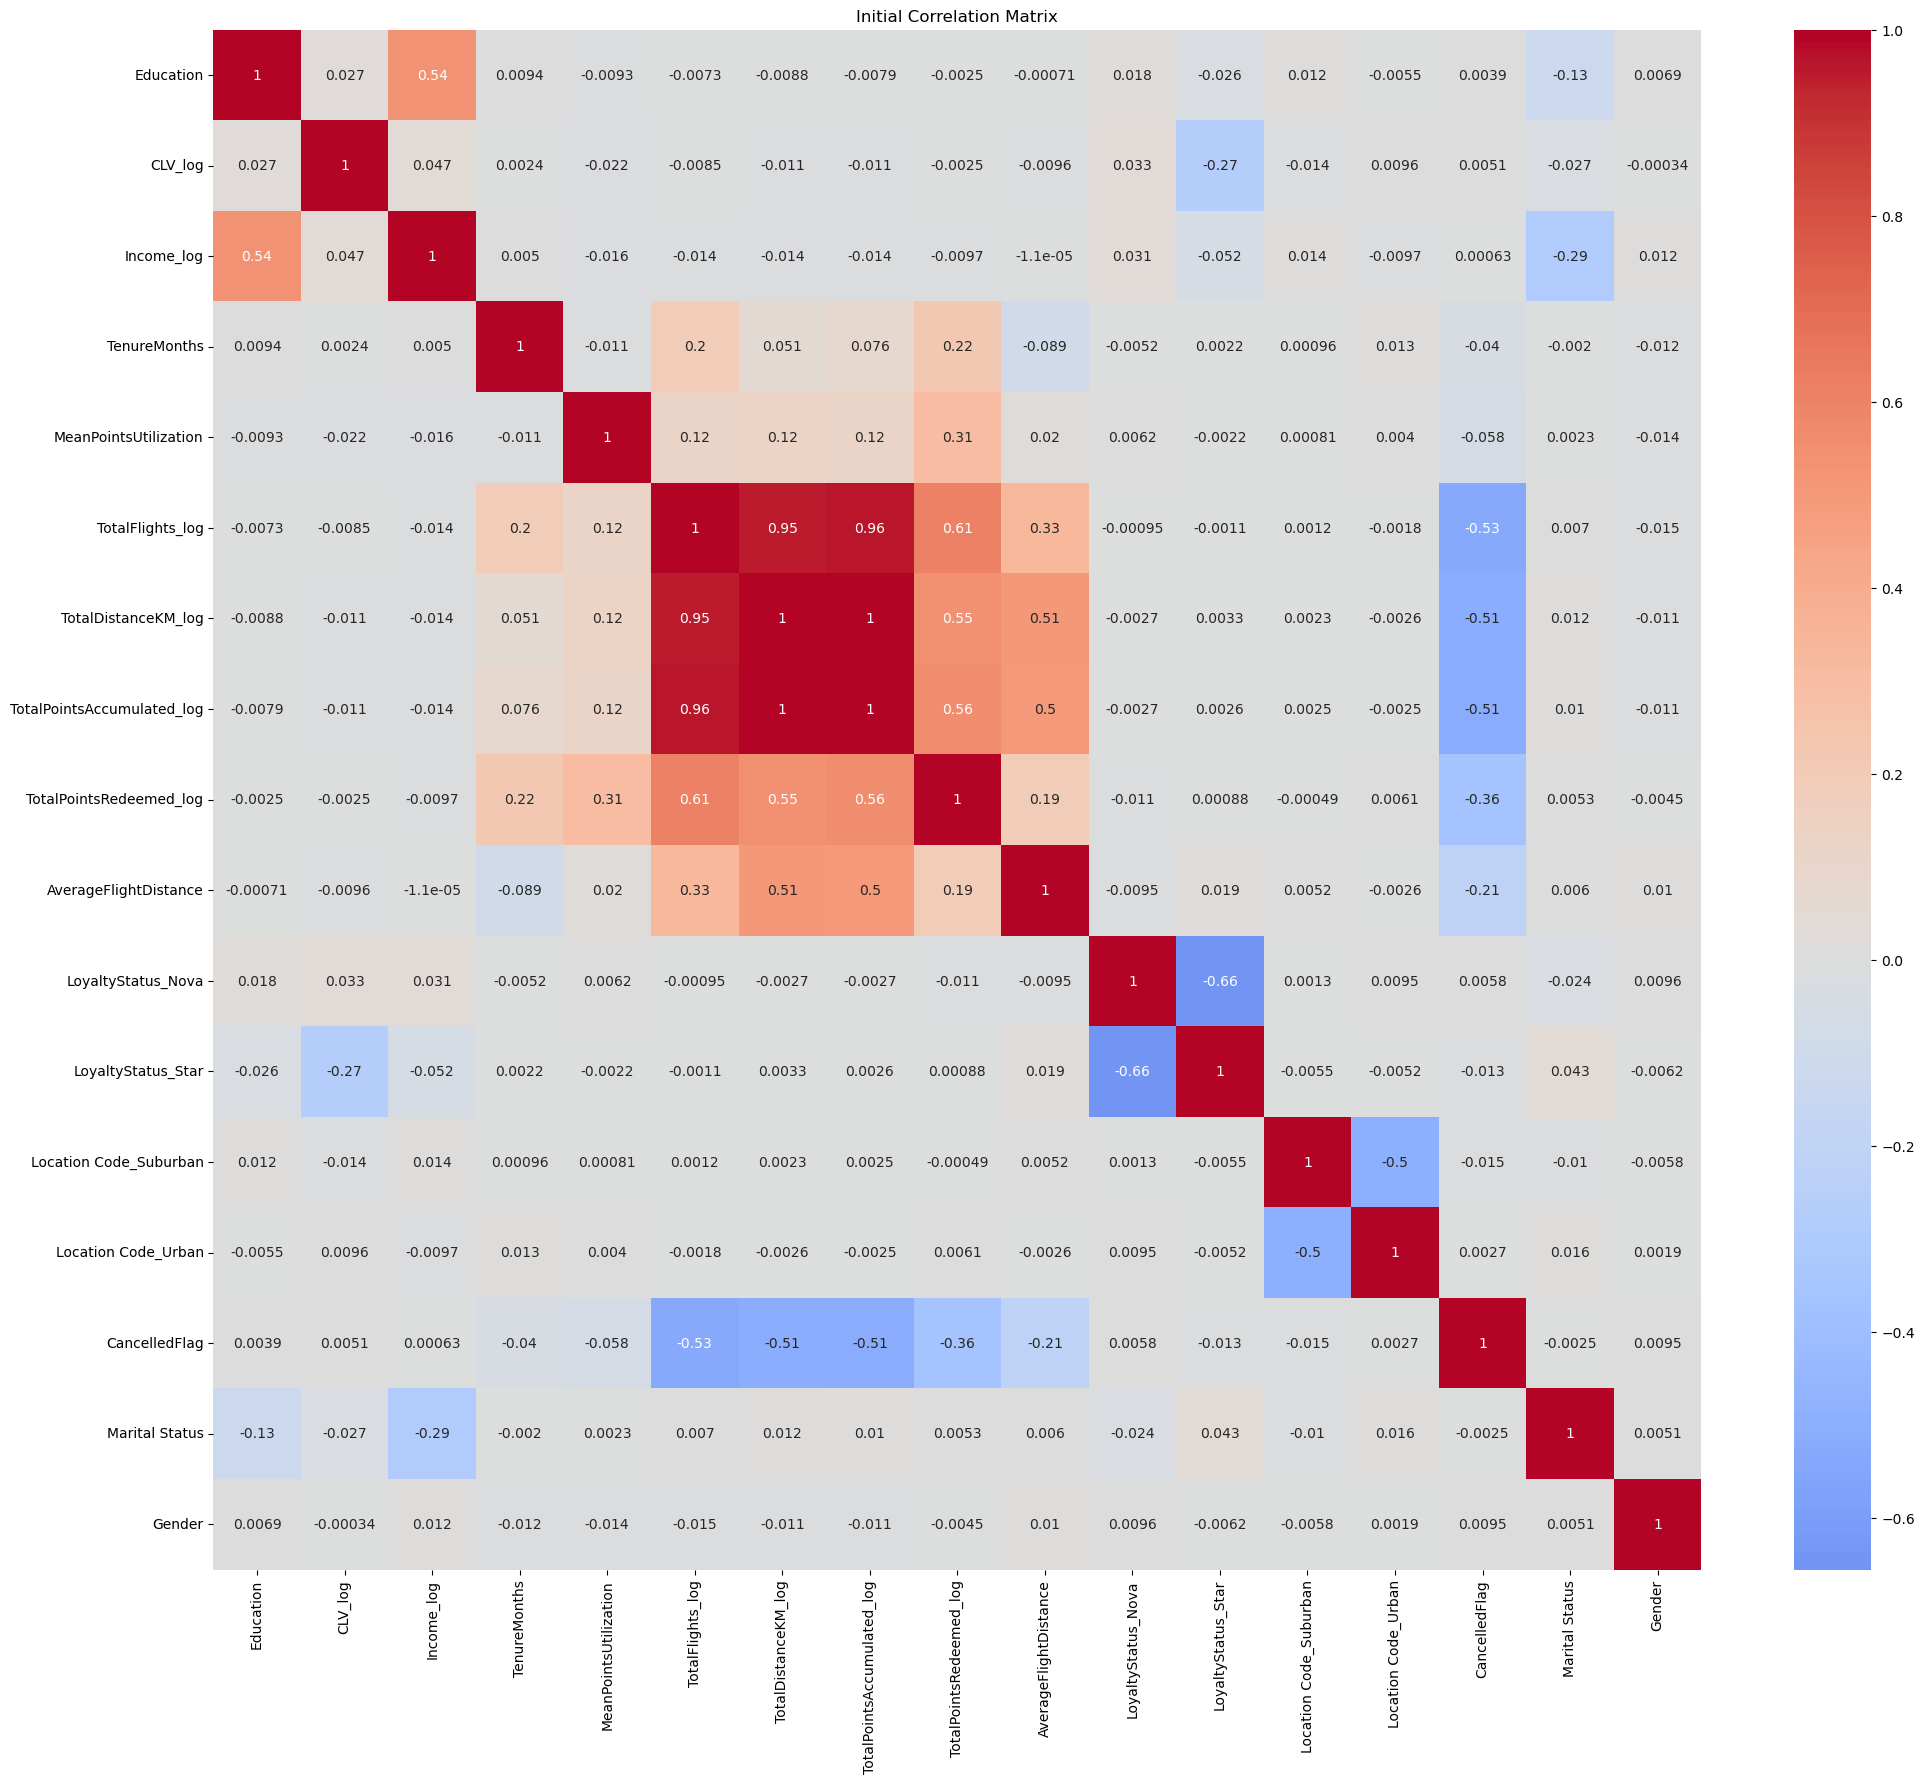

Dropping highly correlated features: ['TotalDistanceKM_log', 'TotalPointsAccumulated_log']
Updated behavior features: ['TotalFlights_log', 'TotalPointsRedeemed_log', 'MeanPointsUtilization', 'AverageFlightDistance']
Updated profile features: ['CLV_log', 'Income_log', 'Gender', 'Education', 'Marital Status', 'LoyaltyStatus_Nova', 'LoyaltyStatus_Star', 'Location Code_Suburban', 'Location Code_Urban', 'TenureMonths', 'CancelledFlag']


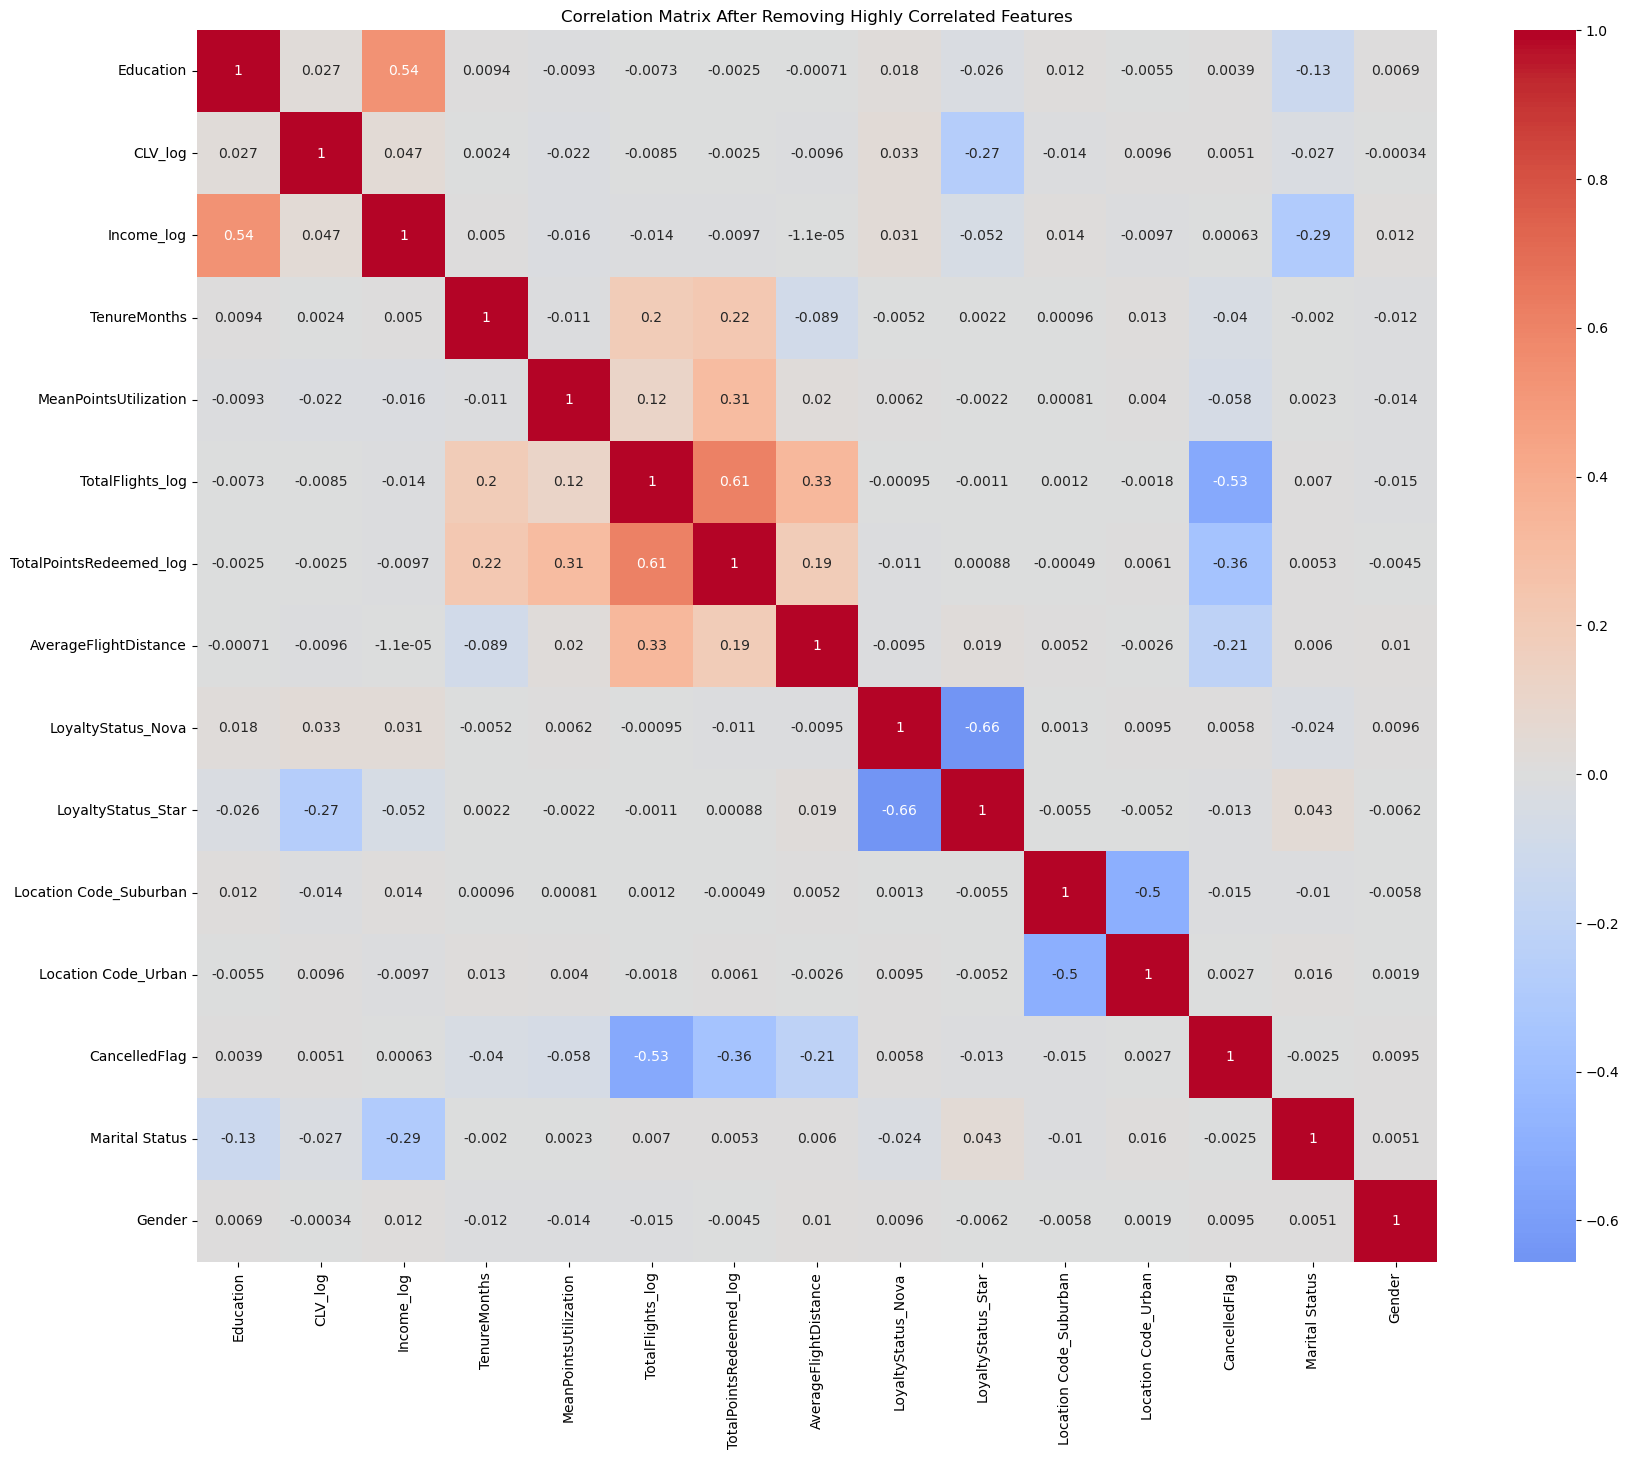

In [8]:
# Correlation Analysis and Feature Selection
# 1. Plot initial correlation matrix
plt.figure(figsize=(24, 20))
initial_corr = model_df.corr()
sns.heatmap(initial_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Initial Correlation Matrix')
plt.show()

# 2. Identify and remove highly correlated features (> 0.8)
# We use the absolute correlation matrix
corr_matrix = model_df.corr().abs()

# We select the upper triangle of the correlation matrix. 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# We drop the column (Feature B) if it has a correlation > 0.8 with any previous column (Feature A).
# This way, Feature A is kept and Feature B is removed.
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

print(f"Dropping highly correlated features: {to_drop}")

# Drop features from model_df
model_df = model_df.drop(columns=to_drop)

# Update feature lists to remove dropped columns
behavior_features = [f for f in behavior_features if f not in to_drop]
profile_features = [f for f in profile_features if f not in to_drop]

print(f"Updated behavior features: {behavior_features}")
print(f"Updated profile features: {profile_features}")

# 3. Plot updated correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(model_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix After Removing Highly Correlated Features')
plt.show()


# Outlier Detection

Detect and remove multivariate outliers using DBSCAN before clustering.

DBSCAN is applied to the scaled feature space for outlier detection. In this project, DBSCAN is used exclusively for identifying anomalous customers, not for final segmentation.

In [9]:
# Use model_df as X_scaled (Loyalty# is now the index)
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=1)
dbscan_labels = dbscan.fit_predict(model_df)

outlier_count = Counter(dbscan_labels)
print(f"DBSCAN results: {outlier_count}")
print(f"Outliers detected: {outlier_count.get(-1, 0)}")
print(f"Core customers: {outlier_count.get(0, 0)}")

core_mask = (dbscan_labels != -1)

model_df_clipped = model_df[core_mask]
outliers_df = model_df[dbscan_labels == -1]

print(f"Core customers kept: {len(model_df_clipped):,}")

DBSCAN results: Counter({np.int64(0): 11590, np.int64(1): 4144, np.int64(2): 656, np.int64(-1): 367})
Outliers detected: 367
Core customers: 11590
Core customers kept: 16,390


# Clustering Algorithms Comparison


## Clustering: Multiple Algorithms & Perspectives

We now test several clustering algorithms (KMeans, DBSCAN, MeanShift) with different hyperparameters, This approach allows us to compare cluster quality and interpretability across perspectives and methods.

In [10]:
# Prepare feature sets for clustering
behavior_df = model_df_clipped[behavior_features]
profile_df = model_df_clipped[profile_features]

## K-means

In [11]:
# KMeans on behavior features
kmeans_param_grid = {'n_clusters': [2, 3, 4, 5, 6], 'init':['k-means++'], 'random_state':[42]}
kmeans_behavior_labels = evaluate_clustering(KMeans, behavior_df, kmeans_param_grid)
kmeans_behavior_labels.value_counts()

KMeans (n_clusters=2, init=k-means++, random_state=42): Clusters=2, Sil=0.59, DB=0.85, R2=0.52
KMeans (n_clusters=3, init=k-means++, random_state=42): Clusters=3, Sil=0.64, DB=0.51, R2=0.76
KMeans (n_clusters=4, init=k-means++, random_state=42): Clusters=4, Sil=0.61, DB=0.7, R2=0.78
KMeans (n_clusters=5, init=k-means++, random_state=42): Clusters=5, Sil=0.6, DB=0.77, R2=0.85
KMeans (n_clusters=6, init=k-means++, random_state=42): Clusters=6, Sil=0.59, DB=0.73, R2=0.87


KMeans_labels
1    11346
0     3491
2     1553
Name: count, dtype: int64

In [12]:
kmeans_profile_labels = evaluate_clustering(KMeans, profile_df, kmeans_param_grid)
kmeans_profile_labels.value_counts()

KMeans (n_clusters=2, init=k-means++, random_state=42): Clusters=2, Sil=0.28, DB=1.53, R2=0.25
KMeans (n_clusters=3, init=k-means++, random_state=42): Clusters=3, Sil=0.2, DB=1.78, R2=0.35
KMeans (n_clusters=4, init=k-means++, random_state=42): Clusters=4, Sil=0.18, DB=1.62, R2=0.41
KMeans (n_clusters=5, init=k-means++, random_state=42): Clusters=5, Sil=0.2, DB=1.46, R2=0.47
KMeans (n_clusters=6, init=k-means++, random_state=42): Clusters=6, Sil=0.17, DB=1.62, R2=0.49


KMeans_labels
1    11532
0     4858
Name: count, dtype: int64

## Meanshift

In [13]:
# MeanShift on behavior features
bandwidth = estimate_bandwidth(behavior_df, quantile=0.2, n_samples=500)
meanshift_param_grid = {'bandwidth': [bandwidth], 'n_jobs': [-1]}
meanshift_behavior_labels = evaluate_clustering(MeanShift, behavior_df, meanshift_param_grid)
meanshift_behavior_labels.value_counts()

MeanShift (bandwidth=1.0499107315106098, n_jobs=-1): Clusters=3, Sil=0.64, DB=0.51, R2=0.76


MeanShift_labels
0    11346
1     3484
2     1560
Name: count, dtype: int64

In [14]:
# MeanShift on profile features
bandwidth = estimate_bandwidth(profile_df, quantile=0.2, n_samples=500)
meanshift_param_grid = {'bandwidth': [bandwidth], 'n_jobs': [-1]}
meanshift_profile_labels = evaluate_clustering(MeanShift, profile_df, meanshift_param_grid)
meanshift_profile_labels.value_counts()

MeanShift (bandwidth=2.489323657413728, n_jobs=-1): Clusters=2, Sil=0.28, DB=1.49, R2=0.25


MeanShift_labels
0    11923
1     4467
Name: count, dtype: int64

## DBSCAN

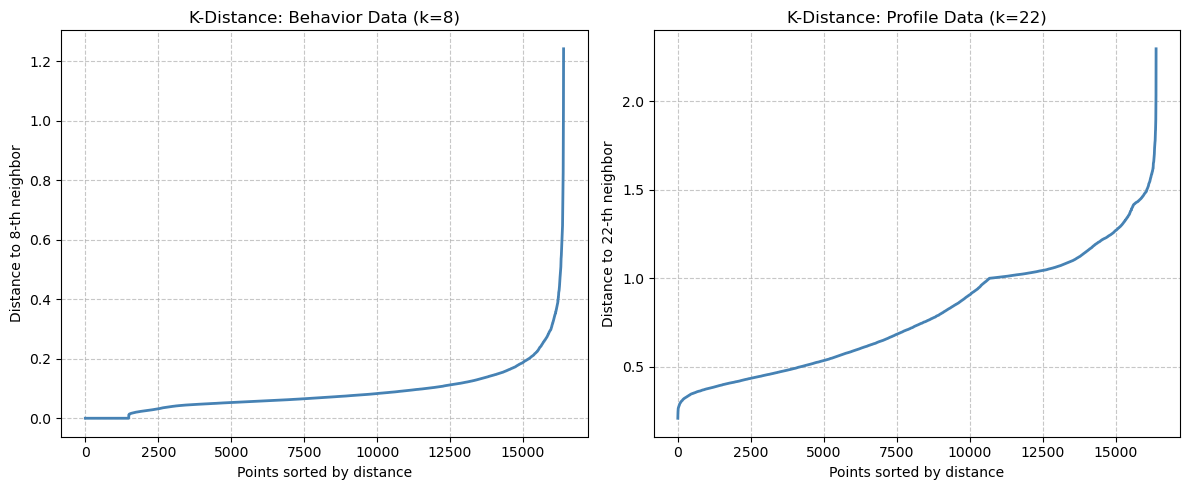

In [15]:
# Create two separate figures
plt.figure(figsize=(12, 5))

# Subplot 1: Behavior DataFrame
ax1 = plt.subplot(1, 2, 1)
plot_k_distance(behavior_df, "Behavior Data", ax=ax1)

# Subplot 2: Profile DataFrame
ax2 = plt.subplot(1, 2, 2)
plot_k_distance(profile_df, "Profile Data", ax=ax2)

plt.tight_layout()
plt.show()


In [16]:
# DBSCAN on profile features
dbscan_param_grid = {'eps': [0.2, 0.3, 0.4], 'min_samples': [10, 15, 20], 'n_jobs': [-1]}
dbscan_behavior_labels = evaluate_clustering(DBSCAN, behavior_df, dbscan_param_grid)
dbscan_behavior_labels.value_counts()    

DBSCAN (eps=0.2, min_samples=10, n_jobs=-1): Clusters=9, Sil=0.36, DB=1.24, R2=0.79
DBSCAN (eps=0.2, min_samples=15, n_jobs=-1): Clusters=5, Sil=0.59, DB=1.01, R2=0.79
DBSCAN (eps=0.2, min_samples=20, n_jobs=-1): Clusters=4, Sil=0.6, DB=1.17, R2=0.78
DBSCAN (eps=0.3, min_samples=10, n_jobs=-1): Clusters=5, Sil=0.63, DB=0.93, R2=0.78
DBSCAN (eps=0.3, min_samples=15, n_jobs=-1): Clusters=5, Sil=0.63, DB=0.97, R2=0.78
DBSCAN (eps=0.3, min_samples=20, n_jobs=-1): Clusters=4, Sil=0.64, DB=1.08, R2=0.78
DBSCAN (eps=0.4, min_samples=10, n_jobs=-1): Clusters=5, Sil=0.64, DB=0.86, R2=0.78
DBSCAN (eps=0.4, min_samples=15, n_jobs=-1): Clusters=4, Sil=0.64, DB=1.05, R2=0.77
DBSCAN (eps=0.4, min_samples=20, n_jobs=-1): Clusters=5, Sil=0.63, DB=1.0, R2=0.78


DBSCAN_labels
 0    11240
 1     3529
 2     1487
-1      126
 3        8
Name: count, dtype: int64

In [17]:
# DBSCAN on profile features
dbscan_param_grid = {'eps': [1.4, 1.5, 1.6], 'min_samples': [10, 15, 20], 'n_jobs': [-1]}
dbscan_profile_labels = evaluate_clustering(DBSCAN, profile_df, dbscan_param_grid)
dbscan_profile_labels.value_counts()   

DBSCAN (eps=1.4, min_samples=10, n_jobs=-1): Clusters=4, Sil=0.27, DB=1.59, R2=0.31
DBSCAN (eps=1.4, min_samples=15, n_jobs=-1): Clusters=4, Sil=0.27, DB=1.75, R2=0.31
DBSCAN (eps=1.4, min_samples=20, n_jobs=-1): Clusters=5, Sil=0.26, DB=1.86, R2=0.35
DBSCAN (eps=1.5, min_samples=10, n_jobs=-1): Clusters=4, Sil=0.27, DB=1.27, R2=0.31
DBSCAN (eps=1.5, min_samples=15, n_jobs=-1): Clusters=4, Sil=0.27, DB=1.54, R2=0.31
DBSCAN (eps=1.5, min_samples=20, n_jobs=-1): Clusters=4, Sil=0.27, DB=1.62, R2=0.31
DBSCAN (eps=1.6, min_samples=10, n_jobs=-1): Clusters=4, Sil=0.28, DB=1.15, R2=0.31
DBSCAN (eps=1.6, min_samples=15, n_jobs=-1): Clusters=4, Sil=0.28, DB=1.15, R2=0.31
DBSCAN (eps=1.6, min_samples=20, n_jobs=-1): Clusters=4, Sil=0.28, DB=1.52, R2=0.31


DBSCAN_labels
 0    11576
 1     4144
 2      669
-1        1
Name: count, dtype: int64

# Self Organizing Maps

Simple workflow: train a SOM per perspective, cluster the SOM codebook with KMeans (use `evaluate_clustering`),
and map neuron clusters back to samples. For each perspective we also plot the U‑matrix and hitmap.

In [18]:
# Train SOM on behavior_df (using som_codebook_for_evaluation)
som_behavior, codebook_beh, bmu_series_beh = som_codebook_for_evaluation(behavior_df)

neuron_labels_beh = evaluate_clustering(KMeans, codebook_beh, verbose = False, param_grid=kmeans_param_grid)

som_labels_beh = bmu_series_beh.map(neuron_labels_beh)

# Calculate silhouette score for SOM clusters on behavior data
som_silhouette_beh = silhouette_score(behavior_df, som_labels_beh)
print(f"SOM Clustering on Behavior Data: Silhouette Score = {som_silhouette_beh:.2f}")

SOM Clustering on Behavior Data: Silhouette Score = 0.59


In [19]:
# Train SOM on behavior_df (using som_codebook_for_evaluation)
som_behavior, codebook_pro, bmu_series_pro = som_codebook_for_evaluation(profile_df)

neuron_labels_pro = evaluate_clustering(KMeans, codebook_pro, verbose=False, param_grid=kmeans_param_grid)

som_labels_pro = bmu_series_pro.map(neuron_labels_pro)

# Calculate silhouette score for SOM clusters on profile data
som_silhouette_pro = silhouette_score(profile_df, som_labels_pro)
print(f"SOM Clustering on Profile Data: Silhouette Score = {som_silhouette_pro:.2f}")

SOM Clustering on Profile Data: Silhouette Score = 0.28


# Next Steps: Merge Cluster Solutions

After identifying the best clustering solutions for each perspective, merge them using hierarchical clustering on the centroids.

In [43]:
beh_labels = kmeans_behavior_labels.copy()
pro_labels = kmeans_profile_labels.copy()

beh_labels = beh_labels.reindex(behavior_df.index)
pro_labels = pro_labels.reindex(profile_df.index)

print("Behavior clusters:", beh_labels.nunique())
print("Profile clusters:", pro_labels.nunique())
print("Rows aligned:", beh_labels.index.equals(pro_labels.index))


Behavior clusters: 3
Profile clusters: 2
Rows aligned: True


In [ ]:
features_for_centroids = list(behavior_df.columns) + [c for c in profile_df.columns if c not in behavior_df.columns]

df = model_df_clipped[features_for_centroids].copy()

df["behavior_cluster"] = kmeans_behavior_labels.reindex(df.index).astype(int)
df["profile_cluster"]  = kmeans_profile_labels.reindex(df.index).astype(int)

df_centroids = df.groupby(["behavior_cluster", "profile_cluster"])[features_for_centroids].mean()

df_centroids

TotalFlights_log  TotalPointsRedeemed_log  \
behavior_cluster profile_cluster                                              
0                0                       -0.015756                -1.479347   
                 1                       -0.063387                -1.479347   
1                0                        0.414952                 0.667028   
                 1                        0.414326                 0.664188   
2                0                       -2.725409                -1.479347   
                 1                       -2.725050                -1.479347   

                                  MeanPointsUtilization  \
behavior_cluster profile_cluster                          
0                0                            -0.429428   
                 1                            -0.429428   
1                0                             0.072596   
                 1                             0.096335   
2                0                            -0.429428   
                 1                            -0.429428   

                                  AverageFlightDistance   CLV_log  Income_log  \
behavior_cluster profile_cluster                                                
0                0                             0.122322 -0.129301   -1.414654   
                 1                             0.155026  0.022343    0.593825   
1                0                             0.116042 -0.072479   -1.392782   
                 1                             0.124005  0.030319    0.591296   
2                0                            -1.652099 -0.059566   -1.416184   
                 1                            -1.650329  0.048466    0.587920   

                                    Gender  Education  Marital Status  \
behavior_cluster profile_cluster                                        
0                0                0.481086  -1.113628        0.603298   
                 1                0.506098   0.437503        0.340650   
1                0                0.496913  -1.126259        0.620700   
                 1                0.503084   0.483689        0.333040   
2                0                0.528169  -1.112228        0.565728   
                 1                0.517303   0.455178        0.338066   

                                  LoyaltyStatus_Nova  LoyaltyStatus_Star  \
behavior_cluster profile_cluster                                           
0                0                          0.317168            0.507274   
                 1                          0.360976            0.436585   
1                0                          0.311673            0.499559   
                 1                          0.344368            0.438011   
2                0                          0.319249            0.488263   
                 1                          0.347826            0.443656   

                                  Location Code_Suburban  Location Code_Urban  \
behavior_cluster profile_cluster                                                
0                0                              0.340446             0.332687   
                 1                              0.341870             0.311789   
1                0                              0.326669             0.328433   
                 1                              0.341724             0.328383   
2                0                              0.323944             0.354460   
                 1                              0.333629             0.326531   

                                  TenureMonths  CancelledFlag  
behavior_cluster profile_cluster                               
0                0                   -0.464354       0.176528  
                 1                   -0.486166       0.182114  
1                0                    0.134584       0.049691  
                 1                    0.150381       0.050850  
2                0                    0.213725      

In [ ]:
# ===== HC on centroids (com tracking de distâncias) =====
import numpy as np
from sklearn.cluster import AgglomerativeClustering
centroid_feature_cols = [c for c in df_centroids.columns if c != "segment_size"]

X_centroids = df_centroids[centroid_feature_cols].values  # matriz (n_centroids x n_features)

hclust = AgglomerativeClustering(
    linkage="ward",
    metric="euclidean",
    distance_threshold=0,
    n_clusters=None
)

hclust_labels = hclust.fit_predict(X_centroids)

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([
    hclust.children_,
    hclust.distances_,
    counts
]).astype(float)

print("Linkage matrix ready for dendrogram!")
print("n_centroids:", X_centroids.shape[0], "| n_features:", X_centroids.shape[1])


Linkage matrix ready for dendrogram!
n_centroids: 6 | n_features: 15


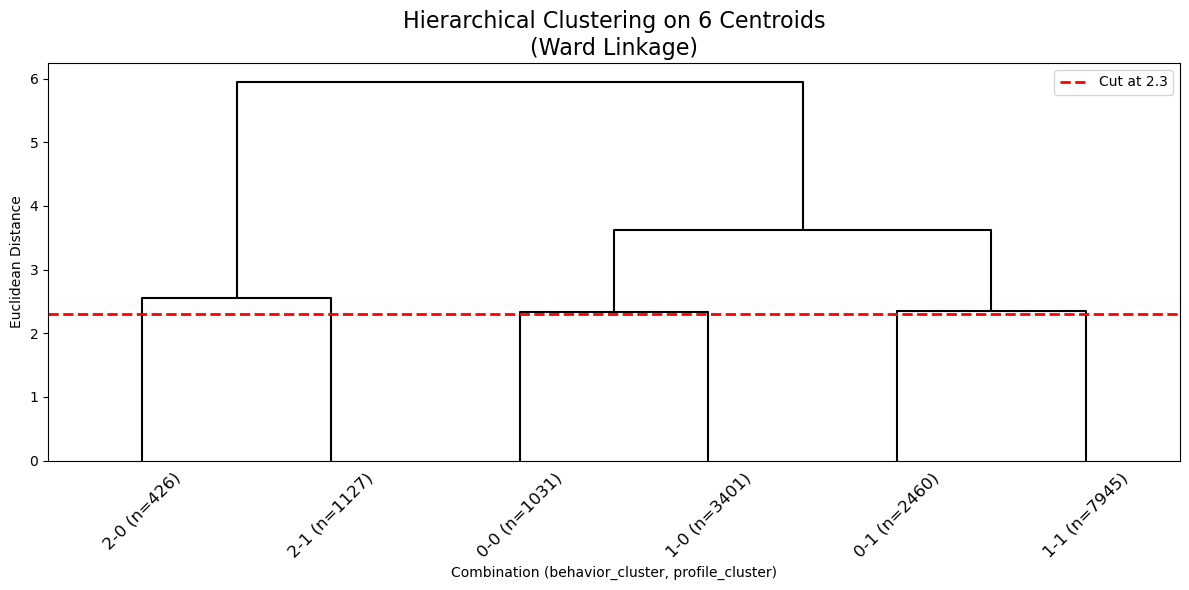

In [63]:
# ===== Plot dendrogram=====
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

fig = plt.figure(figsize=(12, 6))

y_threshold = 2.3

labels = [
    f"{idx[0]}-{idx[1]} (n={int(df_centroids.loc[idx, 'segment_size'])})"
    if "segment_size" in df_centroids.columns
    else f"{idx[0]}-{idx[1]}"
    for idx in df_centroids.index
]

dendrogram(
    linkage_matrix,
    labels=labels,
    color_threshold=y_threshold,
    above_threshold_color="k"
)

plt.axhline(
    y=y_threshold,
    color="r",
    linestyle="--",
    linewidth=2,
    label=f"Cut at {y_threshold}"
)

plt.title(
    f"Hierarchical Clustering on {len(df_centroids)} Centroids\n(Ward Linkage)",
    fontsize=16
)
plt.xlabel("Combination (behavior_cluster, profile_cluster)")
plt.ylabel("Euclidean Distance")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
